# Dataset analysis

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.utils import resample
import numpy as np
import random
from joblib import Parallel, delayed
from collections import deque 


In [77]:
df_ibm = pd.read_csv('../data/2 Year IBM Stock Data.csv', index_col='time')
print(df_ibm[:5])
df_ibm.tail()

                    open    high      low   close  volume
time                                                     
3/25/2022 19:19  131.300  131.30  131.300  131.30     718
3/25/2022 19:18  131.300  131.30  131.300  131.30     282
3/25/2022 17:50  131.300  131.30  131.300  131.30     100
3/25/2022 16:59  131.340  131.35  131.340  131.35    1427
3/25/2022 16:42  131.326  131.35  131.326  131.35    1326


,open,high,low,close,volume
time,,,,,
4/6/2020 7:27,95.385037,95.385037,95.385037,95.385037,854
4/6/2020 7:25,94.530379,94.530379,94.530379,94.530379,450
4/6/2020 7:08,94.703037,94.703037,94.703037,94.703037,436
4/6/2020 7:02,95.479999,95.479999,95.479999,95.479999,575
4/6/2020 7:01,94.979290,94.979290,94.979290,94.979290,452


In [78]:
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216883 entries, 3/25/2022 19:19 to 4/6/2020 7:01
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    216883 non-null  float64
 1   high    216883 non-null  float64
 2   low     216883 non-null  float64
 3   close   216883 non-null  float64
 4   volume  216883 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 9.9+ MB


In [79]:
df_ibm.describe()

,open,high,low,close,volume
count,216883.000000,216883.000000,216883.000000,216883.000000,2.168830e+05
mean,118.568888,118.610088,118.527167,118.568678,1.123028e+04
std,11.032437,11.030216,11.034414,11.032587,2.550945e+04
min,93.893379,94.001154,93.878046,93.894886,0.000000e+00
25%,109.270433,109.306157,109.232227,109.272002,3.895500e+03
50%,116.919510,116.953384,116.880199,116.919510,6.786000e+03
75%,129.697796,129.731458,129.666234,129.700000,1.175100e+04
max,140.686324,140.778433,140.363945,140.658692,2.110106e+06


- cours d'ouverture supérieur a la cloture
- Bollinger (.ta_plot(study='boll'))
- MACD
- moyenne mobile
- chercher les résistances
- capitaux propre par action
- PER = prix action / bénéfice action
- repli / baisse

In [80]:
df_ibm.index = pd.to_datetime(df_ibm.index, format='%m/%d/%Y %H:%M')
df_ibm.head()

,open,high,low,close,volume
time,,,,,
2022-03-25 19:19:00,131.300,131.30,131.300,131.30,718
2022-03-25 19:18:00,131.300,131.30,131.300,131.30,282
2022-03-25 17:50:00,131.300,131.30,131.300,131.30,100
2022-03-25 16:59:00,131.340,131.35,131.340,131.35,1427
2022-03-25 16:42:00,131.326,131.35,131.326,131.35,1326


## Periodic close

In [81]:
close = df_ibm['close']

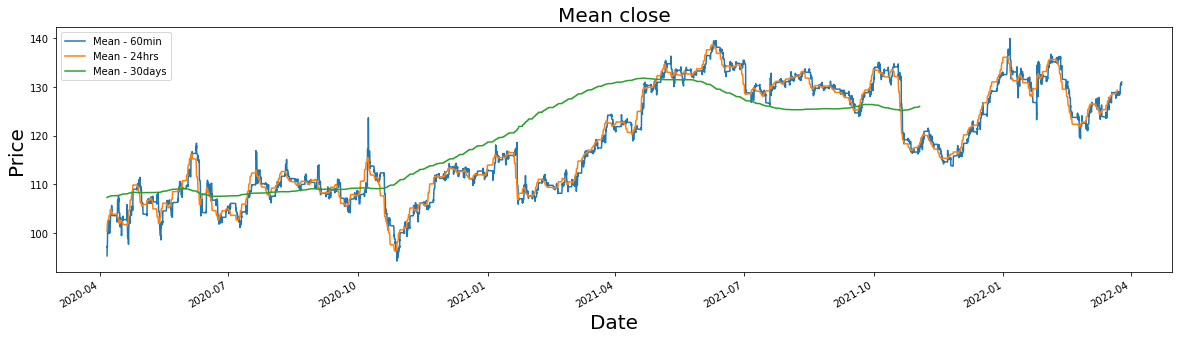

In [82]:
plt.subplots(figsize=(20,5))
close.rolling(window=60).mean().plot(label='Mean - 60min')
close.rolling(window=60*24).mean().plot(label='Mean - 24hrs')
close.rolling(window=60*24*30).mean().plot(label='Mean - 30days')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Mean close', fontsize=20)
plt.legend();

In [83]:
result = adfuller(close[:30_000])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.928673
p-value: 0.318695
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [84]:
close_stationnaire = close.diff().dropna()

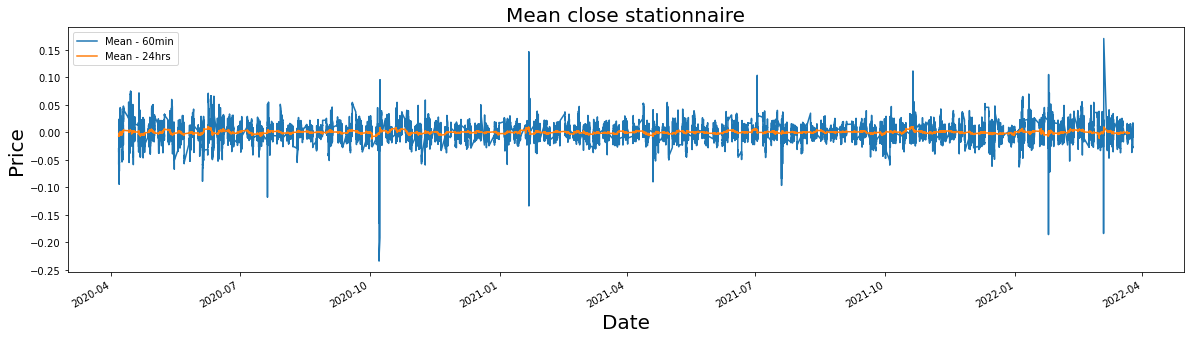

In [85]:
plt.subplots(figsize=(20,5))

close_stationnaire.rolling(window=60).mean().plot(label='Mean - 60min')
close_stationnaire.rolling(window=60*24).mean().plot(label='Mean - 24hrs')

plt.xlabel('Date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Mean close stationnaire', fontsize=20)
plt.legend();

## Mean volume by day

In [86]:
volume = df_ibm['volume']

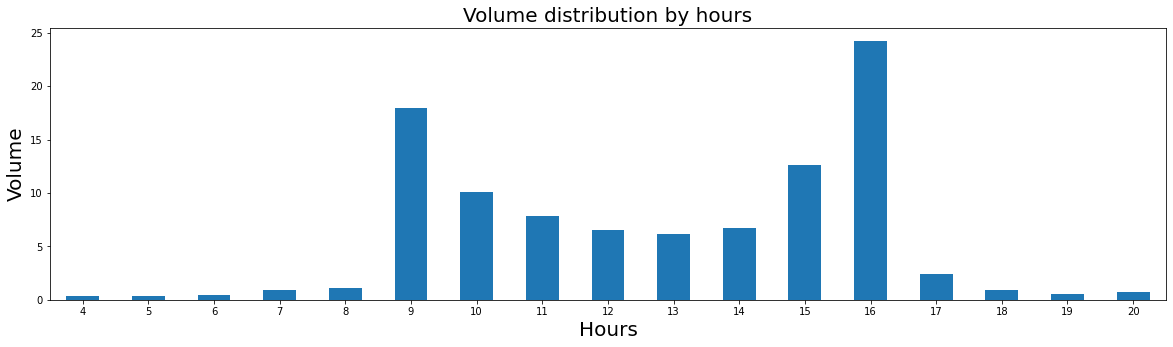

In [87]:
vol_index = volume.index
vol_hours = pd.DataFrame(volume.groupby([vol_index.hour]).mean())
vol_hours['frequency'] = round(vol_hours / vol_hours.values.sum() * 100, 2)

plt.subplots(figsize=(20,5))
vol_hours.frequency.plot(kind='bar')
plt.title('Volume distribution by hours', fontsize=20)
plt.xlabel('Hours', fontsize=20)
plt.xticks(rotation = 0)
plt.ylabel('Volume', fontsize=20);


## Split dataset

In [132]:
def seasonal_bootstrap(df, freq, shift_max=0, n_samples=1, replace=False,
                       n_jobs=1):

    leap_mask = (~((df.index.month == 2) & (df.index.day == 29)))
    new_df = df.copy() #df without leap years
    new_df = new_df[leap_mask]       
    parallel = Parallel(n_jobs=n_jobs)
    
    def create_seasonal_bootstrap(i):
        """
        Returns
        -------
        df_res : pd.DataFrame
            seasonally bootstrapped data
        """
        random.seed(i)
                
        if replace == True:
            index = new_df.index
            blocks = create_blocks(new_df, freq, shift_max)
            #convert list of blocks into array of blocks in order to use indexing
            b = np.empty(len(blocks), dtype=object)
            b[:] = blocks
            blocks = b
            lengths = [len(block) for block in blocks]
            ndays = np.bincount(lengths).argmax()
            blocks_to_shuffle = np.where(lengths == ndays)[0]
            new_indices = np.copy(blocks_to_shuffle)
            new_indices = np.random.choice(new_indices, len(new_indices), replace=True)
            blocks[blocks_to_shuffle]=blocks[new_indices]
                
        else:
            index = df.index
            blocks = create_blocks(df, freq, shift_max)
            random.shuffle(blocks)
        
        #out-of-bag indices
        
                
        df_res =  pd.concat(blocks)

        if isinstance(df_res, pd.DataFrame):
            df_res.set_index(index, inplace=True)
            
        else:
            df_res.index = index
            
        return df_res

    return parallel(delayed(create_seasonal_bootstrap)(i) for i in range(n_samples))

def create_blocks(df, freq, shift_max=0):
  
    shift = random.randint(-shift_max, shift_max)
    df = df.shift(shift)
    #we retrieve groups through the groupby method            
    blocks = deque([gp[1] for gp in df.groupby(pd.Grouper(freq=freq))])
        
    return blocks

bootstrap_samples = seasonal_bootstrap(df=pd.DataFrame(close_stationnaire),
                                       freq='M',
                                       shift_max=0,
                                       n_samples=1,
                                       replace=True,
                                       n_jobs=1)

In [133]:
bootstrap_samples[0].head()

,close
time,
2022-03-25 19:18:00,-0.500709
2022-03-25 17:50:00,0.776962
2022-03-25 16:59:00,0.172658
2022-03-25 16:42:00,-0.854658
2022-03-25 16:06:00,-0.172658


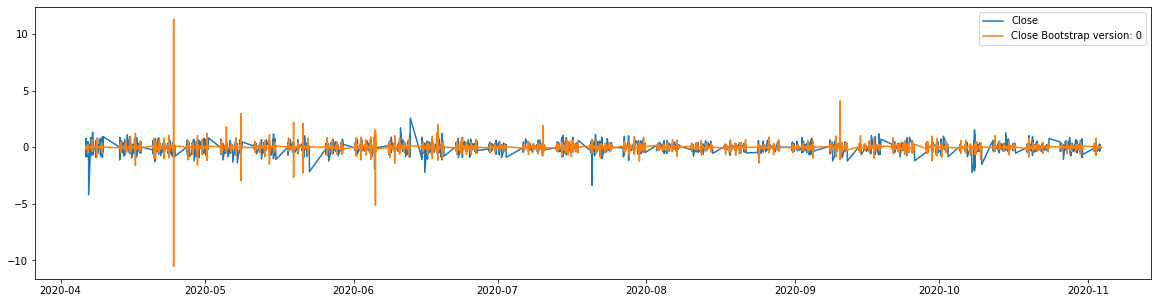

In [134]:
size = round(len(close_stationnaire)*0.3)
for i in range(0, len(bootstrap_samples)):
    plt.subplots(figsize=(20,5))
    plt.subplot( len(bootstrap_samples), 1, (i+1) )
    
    plt.plot(close_stationnaire[-size:], label='Close')
    plt.plot(bootstrap_samples[i][-size:], label='Close Bootstrap version: ' + str(i))
    plt.legend()